In [1]:
!pip install cloudscraper

     |████████████████████████████████| 97 kB 2.5 MB/s 
     |████████████████████████████████| 54 kB 1.9 MB/s 


In [2]:
URL = "https://services.gingersoftware.com/Ginger/correct/jsonSecured/GingerTheTextFull"  # noqa
API_KEY = "6ae0c3a0-afdc-4532-a810-82ded0054236"
class GingerIt(object):
    def __init__(self):
        self.url = URL
        self.api_key = API_KEY
        self.api_version = "2.0"
        self.lang = "US"

    def parse(self, text, verify=True):
        session = cloudscraper.create_scraper()
        request = session.get(
            self.url,
            params={
                "lang": self.lang,
                "apiKey": self.api_key,
                "clientVersion": self.api_version,
                "text": text,
            },
            verify=verify,
        )
        data = request.json()
        return self._process_data(text, data)

    @staticmethod
    def _change_char(original_text, from_position, to_position, change_with):
        return "{}{}{}".format(
            original_text[:from_position], change_with, original_text[to_position + 1 :]
        )

    def _process_data(self, text, data):
        result = text
        corrections = []

        for suggestion in reversed(data["Corrections"]):
            start = suggestion["From"]
            end = suggestion["To"]

            if suggestion["Suggestions"]:
                suggest = suggestion["Suggestions"][0]
                result = self._change_char(result, start, end, suggest["Text"])

                corrections.append(
                    {
                        "start": start,
                        "text": text[start : end + 1],
                        "correct": suggest.get("Text", None),
                        "definition": suggest.get("Definition", None),
                    }
                )

        return {"text": text, "result": result, "corrections": corrections}

In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re, os, logging, time, pickle, itertools, numpy as np
from collections import Counter

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import requests, cloudscraper
from shutil import rmtree
from pathlib import Path
from re import findall

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 'can', 'will', 'just', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain']
stemmer = SnowballStemmer("english")

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
path_to_source_folder = '/content/drive/MyDrive/Rohit/training.1600000.processed.noemoticon.csv.zip'
# model_out = Path('/content/drive/MyDrive/20frame_20classmodel')
# batch_size = 100
ACCURACY_THRESHOLD = 0.95
split_ratio = 0.2       #training validation split

In [ ]:
make_dir = Path('/content/dataset')
if make_dir.exists(): rmtree(make_dir)
make_dir.mkdir()

if findall('.7z', str(path_to_source_folder)):
    with py7zr.SevenZipFile(path_to_source_folder, mode='r') as z:
        z.extractall('/content/dataset')
    path_to_source_folder = Path('/content/dataset')
elif findall('.zip', str(path_to_source_folder)):
    !unzip $path_to_source_folder -d /content/dataset
    path_to_source_folder = Path('/content/dataset/')
else:
    path_to_source_folder = Path(path_to_source_folder)

Archive:  /content/drive/MyDrive/Rohit/training.1600000.processed.noemoticon.csv.zip
  inflating: /content/dataset/training.1600000.processed.noemoticon.csv  


In [ ]:
dataset_filename = os.listdir(path_to_source_folder)[0]
dataset_path = os.path.join(path_to_source_folder,dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/dataset/training.1600000.processed.noemoticon.csv


In [ ]:
print("Dataset size:", len(df))
print(df.head(5))

Dataset size: 1600000
   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [ ]:
decode_map = {0: 0, 4: 1}
df.target = df.target.apply(lambda x: decode_map[int(x)])

Text(0.5, 1.0, 'Dataset labels distribuition')

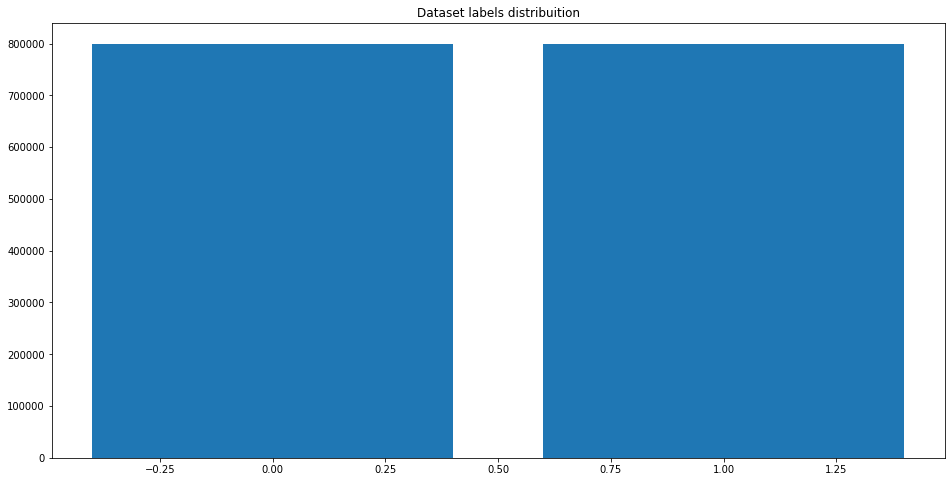

In [ ]:
target_cnt = Counter(df.target)
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
count  = 0
count1 = 0
for i in df['target']:
    if i == 0:
        count+=1
    elif i ==1:
        count1+=1
print(count, "  ", count1)

800000    800000


In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    # print("Before gingerit  : ", text)
    text = parser.parse(text)
    corrections = text['corrections']
    text = text['text']
    # print("Corrections      : ", corrections)
    # print("After gingerit   : ", text)
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    # print("After Stopwords and Stemmer : ", tokens)
    # print("------------------------------------------------------------------------------------------")
    pbar.update(1)
    return " ".join(tokens)

Corrections      :  []
After gingerit   :  Your name what


In [ ]:
%%time
from tqdm import tqdm
parser = GingerIt()
pbar = tqdm(total=len(df.text), bar_format ='{l_bar}{bar}|  {n_fmt}/{total_fmt}  [ Elapsed Time : {elapsed} | ETA : {remaining} ]', leave=True, position=0)
new_df= pd.DataFrame()
new_df.text = df.text.apply(lambda x: preprocess(x))

  0%|          |  5351/1600000  [ Elapsed Time : 1:00:01 | ETA : 388:13:48 ]

JSONDecodeError: ignored

In [ ]:
print(len(new_df))

0


In [ ]:
print(df.text[5351])

@bradiewebbstack omg am i being a stalker or WHAT?! i'm having a 1 sided convo with myself...through ur twitter  bradiekins &lt;-- haha


In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))


In [ ]:
%%time
documents = [_text.split() for _text in df_train.text]

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [9]:
!git clone https://github.com/myint/language-check

Cloning into 'language-check'...
remote: Enumerating objects: 1427, done.
remote: Total 1427 (delta 0), reused 0 (delta 0), pack-reused 1427
Receiving objects: 100% (1427/1427), 610.08 KiB | 6.70 MiB/s, done.
Resolving deltas: 100% (663/663), done.


In [20]:
!python /content/language-check/setup.py install

Traceback (most recent call last):
  File "/content/language-check/setup.py", line 595, in <module>
    sys.exit(main())
  File "/content/language-check/setup.py", line 590, in main
    run_setup_hooks(config)
  File "/content/language-check/setup.py", line 561, in run_setup_hooks
    language_tool_hook(config)
  File "/content/language-check/setup.py", line 584, in language_tool_hook
    download_lt()
  File "/content/language-check/download_lt.py", line 147, in download_lt
    data_len += len(data)
TypeError: object of type 'generator' has no len()


In [ ]:
from tqdm import tqdm
parser = GingerIt()
text = 'Your name what'
text = parser.parse(text)
corrections = text['corrections']
text = text['text']
print("Corrections      : ", corrections)
print("After gingerit   : ", text)

In [ ]:
!git clone -b patch-1 https://github.com/SpartorA/language-check.git
!pip install /content/language-check
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y --no-install-recommends openjdk-8-{jre,jdk}-headless openjdk-8-jre     #install openjdk
  #   !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #ALTERNATIVE METHOD install openjdk
  !update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version        #check java version should be "1.8.0_312"
install_java()

In [51]:
import language_check
tool = language_check.LanguageTool('en-US')

In [64]:
text = 'your name what'
matches = tool.check(text)
fixes = language_check.correct(text, matches)
print("Corrections      : ", matches)
print("After gingerit   : ", fixes)

Corrections      :  [Match({'fromy': 0, 'fromx': 0, 'toy': 0, 'tox': 4, 'ruleId': 'UPPERCASE_SENTENCE_START', 'msg': 'This sentence does not start with an uppercase letter', 'replacements': ['Your'], 'context': 'your name what', 'contextoffset': 0, 'offset': 0, 'errorlength': 4, 'category': 'Capitalization', 'locqualityissuetype': 'typographical'})]
After gingerit   :  Your name what


update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
